In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from openpyxl import load_workbook
#from shapely.geometry import Point, LineString
#import shapely, shapely.prepared

In [3]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

In [127]:
discountrate = 0.04
NoOfPeakSeason = 2
lengthPeakSeason = 24 # Usually 24
NoOfRegSeason = 4
lengthRegSeason = 168
LeapYearsInvestment = 5
fix_sample = 'random' # fix_sample = True --> 'no', fix_sample = False = 'random'
season_scale = [(8760 - NoOfPeakSeason * lengthPeakSeason) / NoOfRegSeason / lengthRegSeason
                            for x in range(NoOfRegSeason)] + [1 for x in range(NoOfPeakSeason)]
new_names = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro ror', 'Hydro storage', 'Geothermal']
new_names_2 = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro', 'Geothermal']
old_names = ['Gas CCGT',    'Gas OCGT',  'Bio',   'Oil existing',  'Wind onshore',  'Solar'  ,'Hydro run-of-the-river', 'Hydro regulated', 'Geo']
scenario = '1'
date = '0522'
time = '0948'



file_path = 'Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time + '/results_output_EuropePlot.csv'
operational_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_Operational.csv')
investment_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_gen.csv')
objective_value = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_objective.csv', header=None)
transmission_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_transmision.csv')
stor_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_stor.csv')
node_sheet = load_workbook('Data handler/bolivia_v1/Node.xlsx')

scenario_int = int(scenario)
prob_scenarios = {f"scenario{i}": 1/scenario_int for i in range(1,scenario_int+1)}
regular_seasons = ['winter', 'spring', 'summer', 'fall']
peak_seasons = ['peak1', 'peak2']

In [128]:
# Helper functions
def get_colors(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, teal2, brown2]
    color_dict = dict(zip(new_names_2, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def rename_columns(df):
    old_names_no_space = [names.replace(" ", "") for names in old_names]
    name_map= dict(zip(old_names_no_space, new_names))
    df = df.rename(columns=name_map)
    return df

def open_csv(file, included_rows):
    data_list = []
    with open(file, 'r') as f:
        next(f)
        headers = f.readline().strip().split(',')  # Read the first line to get headers
        for i, line in enumerate(f, start=2):  # Start counting from 2 since headers are at line 1
            if i in included_rows:
                # Split the line by comma, or change delimiter as necessary
                values = line.strip().split(',')
                # Create a dictionary for the row using a dictionary comprehension and zip to pair headers and values
                row_data = dict(zip(headers, values))
                data_list.append(row_data)
    return pd.DataFrame(data_list)

def rename_columns_operations(df):
    operations_names = ['GasCCGT_MW', 'GasOCGT_MW', 'Bio_MW', 'Oilexisting_MW', 'Windonshore_MW', 'Solar_MW', 'Hydrorun-of-the-river_MW', 'Hydroregulated_MW', 'Geo_MW']
    name_map= dict(zip(operations_names, new_names))
    df = df.rename(columns=name_map)
    return df

def custom_autopct(pct):
    return ('%1.1f%%' % pct)# if pct > 0 else ''

def get_marginal_cost(technology):
    generator_file = load_workbook('Data handler/bolivia_v1/Generator.xlsx')
    generator_efficiency = generator_file['Efficiency']
    generator_VOM = generator_file['VariableOMCosts']
    generator_fuel_cost = generator_file['FuelCosts']

    for row in range(2, generator_efficiency.max_row + 1):  
        if generator_efficiency.cell(row, 1).value == technology:
            efficiency = generator_efficiency.cell(row, 3).value  
            break  

    for row in range(2, generator_VOM.max_row + 1):
        if generator_VOM.cell(row, 1).value == technology:
            VOM = generator_VOM.cell(row, 2).value 
            break

    for row in range(2, generator_fuel_cost.max_row + 1):
        if generator_fuel_cost.cell(row, 1).value == technology:
            fuel_cost = generator_fuel_cost.cell(row, 3).value 
            break
        
    return (3.6/efficiency)*fuel_cost + VOM


           Hydro storage  Hydro ror         OCGT  Biomass     CCGT    Oil  \
                                                                            
Initial           371.13     363.72   527.610000   127.72  1343.07  12.00   
2025-2030         371.13     363.72   527.610000   127.72  1343.07  12.00   
2030-2035         368.58     363.72   624.594997   127.72  1343.07   8.66   
2035-2040         356.15     345.42  1224.382450   106.72  1343.07   6.46   

            Wind   Solar    Geothermal  
                                        
Initial    131.4  165.08  0.000000e+00  
2025-2030  131.4  165.08  1.179433e-13  
2030-2035  131.4  165.08  1.991765e-13  
2035-2040   27.0  160.08  2.539028e-13  


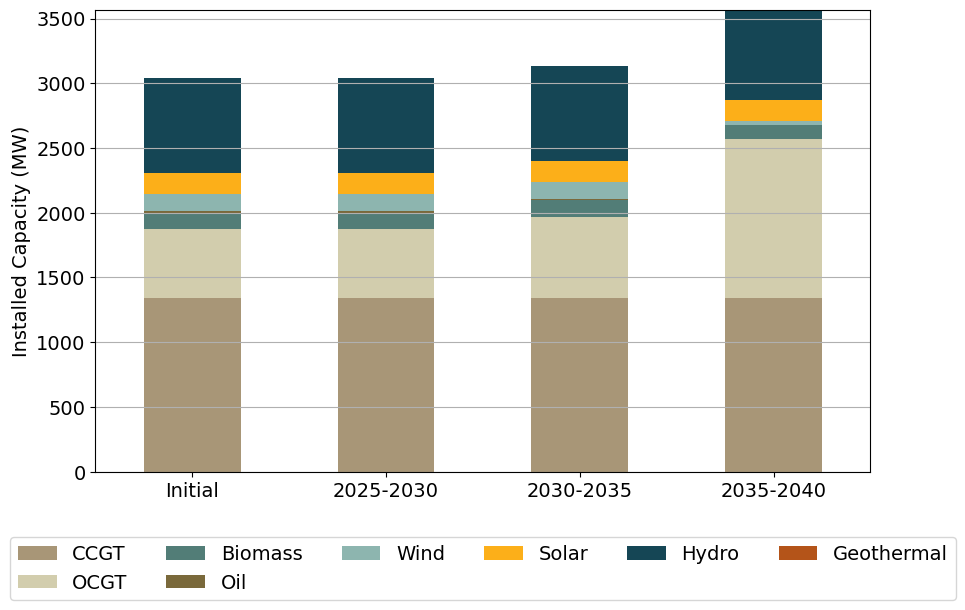

              CCGT         OCGT  Biomass    Oil   Wind   Solar   Hydro  \
                                                                         
Initial    1343.07   527.610000   127.72  12.00  131.4  165.08  734.85   
2025-2030  1343.07   527.610000   127.72  12.00  131.4  165.08  734.85   
2030-2035  1343.07   624.594997   127.72   8.66  131.4  165.08  732.30   
2035-2040  1343.07  1224.382450   106.72   6.46   27.0  160.08  701.57   

             Geothermal  
                         
Initial    0.000000e+00  
2025-2030  1.179433e-13  
2030-2035  1.991765e-13  
2035-2040  2.539028e-13  


In [129]:

included_rows = [2,3,4,5]
installed_cap = open_csv(file_path, included_rows)
installed_cap.set_index('', inplace=True)

for column in installed_cap.columns:
    installed_cap[column] = pd.to_numeric(installed_cap[column], errors='coerce')

installed_cap = rename_columns(installed_cap)
print(installed_cap)
installed_cap['Hydro'] = installed_cap['Hydro ror'] + installed_cap['Hydro storage']
installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
installed_cap = installed_cap[['CCGT', 'OCGT', 'Biomass', 'Oil', 'Wind', 'Solar', 'Hydro', 'Geothermal']]
installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(installed_cap.columns))

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

print(installed_cap)

In [157]:
get_marginal_cost('Gas CCGT')

13.4

In [159]:
get_marginal_cost('Gas OCGT')

15.085714285714287

In [130]:
period_intervals = installed_cap.transpose().columns[1:]
period_intervals

Index(['2025-2030', '2030-2035', '2035-2040'], dtype='object', name='')

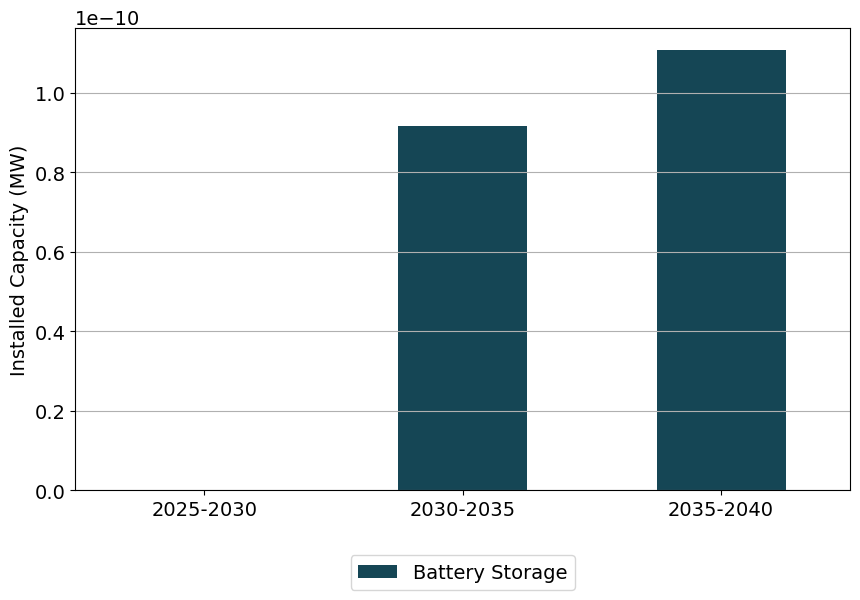

In [131]:
included_rows = [21, 22, 23]
installed_battery = open_csv(file_path, included_rows)
installed_battery.set_index('', inplace=True)

for column in installed_battery.columns:
    installed_battery[column] = pd.to_numeric(installed_battery[column], errors='coerce')

installed_battery.plot(kind='bar', stacked=True, figsize=(10, 6), color=teal2)

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14, labels=['Battery Storage'])
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

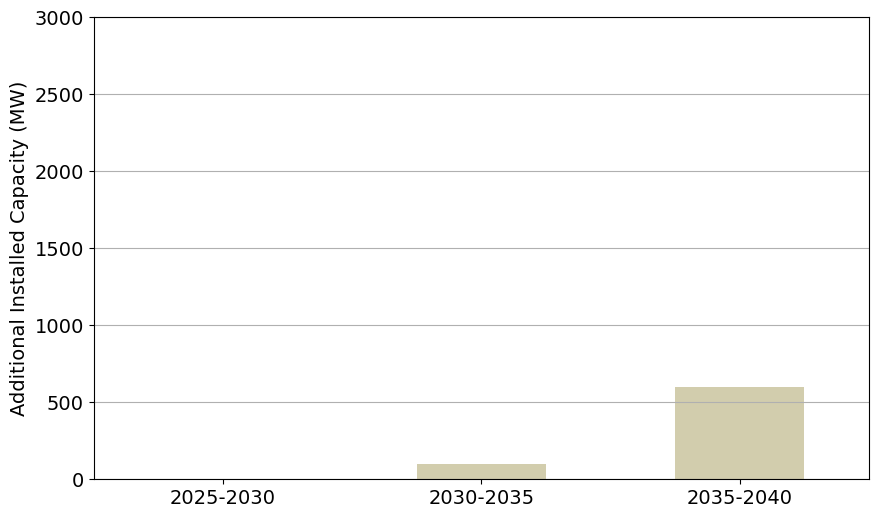

           CCGT        OCGT  Biomass  Hydro   Oil    Geothermal          Wind  \
                                                                                
2025-2030   0.0    0.000000      0.0   0.00  0.00  1.179433e-13  2.643219e-12   
2030-2035   0.0   96.984997      0.0  -2.55 -3.34  8.123325e-14  6.821210e-13   
2035-2040   0.0  599.787453    -21.0 -30.73 -2.20  5.472627e-14 -1.044000e+02   

                  Solar  
                         
2025-2030  3.552714e-12  
2030-2035  9.663381e-13  
2035-2040 -5.000000e+00  


In [132]:
# New installed capacity
new_installed_cap = installed_cap.diff()
new_installed_cap = rename_columns(new_installed_cap)
# new_installed_cap['Hydro'] = new_installed_cap['Hydro ror'] + new_installed_cap['Hydro storage']
# new_installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
new_installed_cap = new_installed_cap.dropna()
new_installed_cap = new_installed_cap[['CCGT', 'OCGT', 'Biomass', 'Hydro', 'Oil', 'Geothermal', 'Wind', 'Solar']]
new_installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(new_installed_cap.columns), legend=False)

plt.ylabel('Additional Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.ylim(0, 3000)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/NewInstalledCapacity.png', bbox_inches='tight')
plt.show()

print(new_installed_cap)  

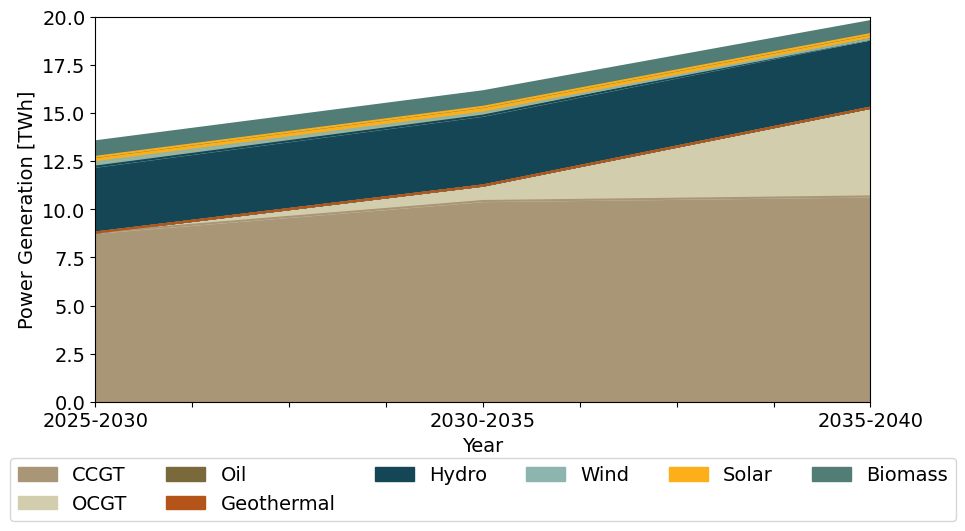

In [133]:
included_rows = [9,10,11]

dispatch = open_csv(file_path, included_rows)
dispatch.set_index('', inplace=True)
for column in dispatch.columns:
    dispatch[column] = pd.to_numeric(dispatch[column], errors='coerce')

dispatch = rename_columns(dispatch)

dispatch /= 1000
dispatch['Hydro'] = dispatch['Hydro ror'] + dispatch['Hydro storage']
dispatch.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)

# reorder columns to ['CCGT',   'OCGT',  'Oil',  'Geothermal' , 'Hydro', 'Wind', 'Solar',   'Biomass']
dispatch = dispatch[['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]

production_plot = dispatch.plot.area(stacked=True, color=get_colors(dispatch.columns),figsize=(10, 5))
production_plot.set_xlim(0,2)
plt.ylabel('Power Generation [TWh]', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/Production.png', bbox_inches='tight')

In [134]:
dispatch

,CCGT,OCGT,Oil,Geothermal,Hydro,Wind,Solar,Biomass
,,,,,,,,
2025-2030,8.784972,0.007449,8.941761e-16,7.228797e-16,3.424329,0.228140,0.278898,0.807254
2030-2035,10.430095,0.808156,1.291113e-04,1.324449e-15,3.626328,0.161582,0.297066,0.807254
2035-2040,10.667793,4.613225,3.040929e-05,1.718703e-15,3.550815,0.005101,0.262692,0.674524


In [135]:
dispatch.transpose().sum()


2025-2030    13.531041
2030-2035    16.130610
2035-2040    19.774179
dtype: float64

C:\Users\marih\AppData\Local\Temp\ipykernel_32484\2069360540.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)


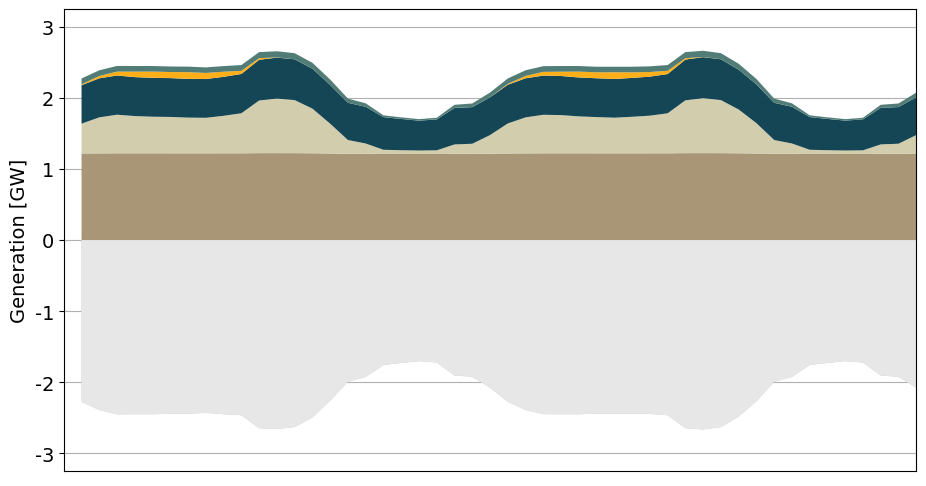

In [136]:
period = '2035-2040'
scenario_number = 'scenario1'
 
filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == scenario_number)]
old_names_no_space = [names.replace(" ", "") for names in old_names]
snapshot_columns = [tech + '_MW' for tech in old_names_no_space]
snapshot_columns.append('storDischarge_MW')
snapshot_columns.append('storCharge_MW')
snapshot_columns.append('Hour')
snapshot_columns.append('Load_MW')
snapshot_columns.append('LoadShed_MW')
snapshots = filtered_data[snapshot_columns]
snapshots.loc[:,'Hydrorun-of-the-river_MW'] = snapshots['Hydrorun-of-the-river_MW'] + snapshots['Hydroregulated_MW']
snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)
 
# Sum based on Hour and then plot aggregated snapshots
snapshots = snapshots.groupby('Hour').sum()
snapshots = snapshots[['GasCCGT_MW', 'GasOCGT_MW', 'Oilexisting_MW', 'Geo_MW', 'Hydrorun-of-the-river_MW', 'Windonshore_MW', 'Solar_MW', 'Bio_MW', 'storDischarge_MW', 'storCharge_MW', 'Load_MW', 'LoadShed_MW']]
fig, ax=plt.subplots(figsize = (11,6))
columns_to_plot = [col for col in snapshots.columns if col not in ['Hour', 'storCharge_MW', 'Load_MW']]
colors= [beige2, beige3, beige1, brown2, teal2, teal4, yellow, teal3, grey4, red1]
dispatch_plot = plt.stackplot(snapshots.index, [snapshots[col] for col in columns_to_plot], colors=colors, zorder=2)
plt.stackplot(snapshots.index, snapshots['storCharge_MW'] + snapshots['Load_MW'], labels=['storCharge_MW'], colors=[grey3], zorder=2)
plt.stackplot(snapshots.index, snapshots['Load_MW'], labels=['Load'], colors=[grey1], zorder=2)
#plt.xticks(rotation = 0, fontsize=14)
# Remove xticks
plt.xticks([])
plt.yticks(fontsize=14)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
# myFmt = mdates.DateFormatter('%d %b')
# ax.xaxis.set_major_formatter(myFmt)
all_labels = new_names_2 + ['Battery discharge'] +['Load shedding'] + ['Battery charge'] + ['Load']
#plt.legend(labels=all_labels,loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=6, fontsize=14)
ax.set_ylabel('Generation [GW]', fontsize=14)
ax.set_xlim(0, 2*24)
ax.set_ylim(-3250, 3250)
ax.grid(axis='y')
plt.savefig('figures/Dispatch.png', bbox_inches='tight')

In [137]:
snapshots.sum()

GasCCGT_MW                  8.771105e+05
GasOCGT_MW                  3.922133e+05
Oilexisting_MW              3.040929e+01
Geo_MW                      1.387582e-10
Hydrorun-of-the-river_MW    2.877332e+05
Windonshore_MW              3.991900e+02
Solar_MW                    2.196961e+04
Bio_MW                      5.675683e+04
storDischarge_MW            5.462741e-09
storCharge_MW              -6.828426e-09
Load_MW                    -1.636213e+06
LoadShed_MW                 5.931859e-15
dtype: float64

In [138]:
3.338593e+03*8e6


26708744000.0

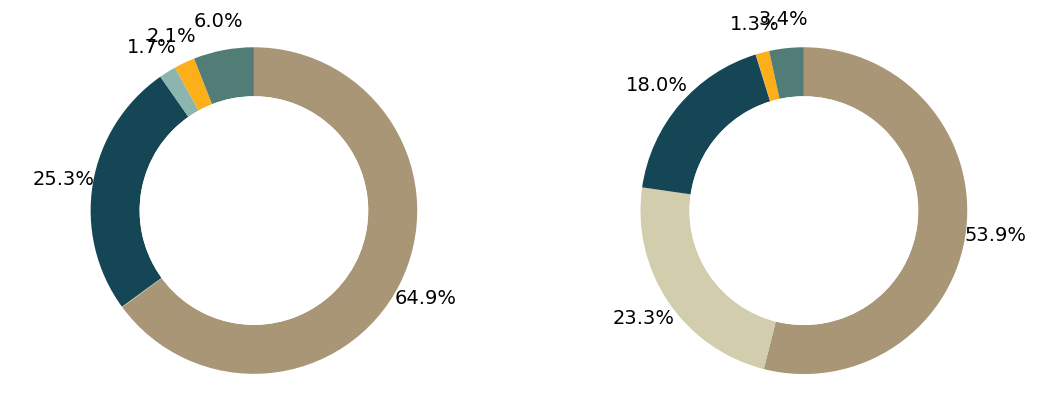

In [139]:

dispatch_firstperiod = dispatch[:1][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
dispatch_lastperiod = dispatch[-1:][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
 
plt.rcParams['font.size'] = 14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
 
wedges1, texts1, autotexts1 = ax1.pie(
    dispatch_firstperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_firstperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.18
)
 
wedges2, texts2, autotexts2 = ax2.pie(
    dispatch_lastperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_lastperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.18
    
)
 
for autotext in autotexts1 + autotexts2:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)
 
centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
#ax1.set_title("2025 - 2030" +' Power Mix')
 
centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
#ax2.set_title("2035 - 2040" +' Power Mix')
 
ax1.axis('equal')
ax2.axis('equal')
 
#fig.legend(dispatch_lastperiod.columns, loc="center right", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout(pad=3.0)




1955.9417939187194


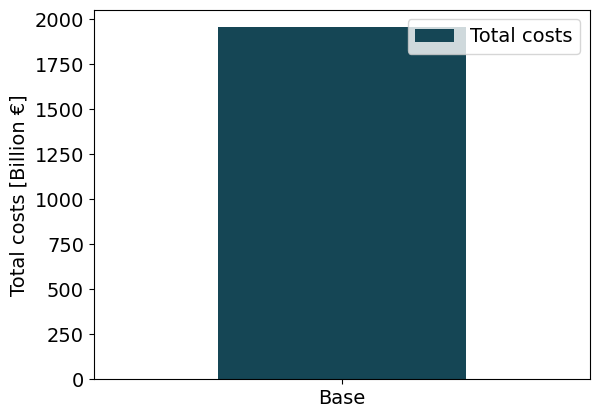

In [140]:
total_costs = objective_value.iloc[0,1] /1e6
total_costs_df = pd.DataFrame(total_costs, index=['Base'],  columns=['Total costs'])
print(total_costs)
total_costs_df.plot(kind='bar', color=teal2)
plt.ylabel('Total costs [Billion €]', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)

plt.show()

NPV:  1955.9417939186915


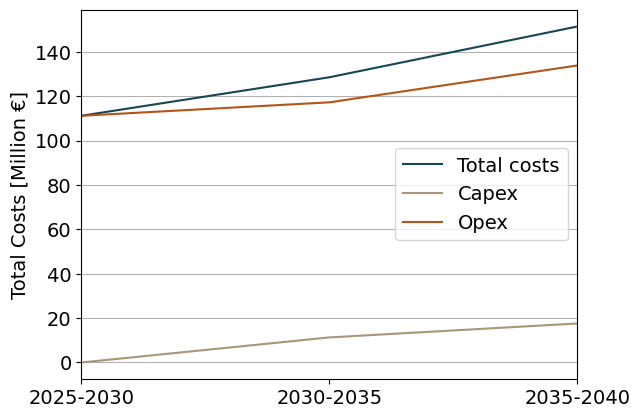

In [141]:
periods = ['2025-2030', '2030-2035', '2035-2040']
load_shed_cost = node_sheet['NodeLostLoadCost']['C4'].value
capex_dict = {}
for period in periods:
    sum_capex = (investment_data[(investment_data['Period'] == period)]['DiscountedInvestmentCost_Euro'].sum() 
                 + transmission_data[(transmission_data['Period'] == period)]['DiscountedInvestmentCost_EuroPerMW'].sum() 
                 + stor_data[(stor_data['Period'] == period)]['DiscountedInvestmentCostPWEN_EuroPerMWMWh'].sum())
    capex_dict[period] = sum_capex / 1e6 

capex = pd.DataFrame(list(capex_dict.items()), columns=['Period', 'TotalInvestment'])

operational_scalar = sum((1+discountrate)**(-j) for j in list(range(0,LeapYearsInvestment)))

opex_dict = {}
for period, num_period in zip(periods, range(1, len(periods) + 1)):
    sum_opex = 0
    coeff = 1
    if num_period > 1:
        coeff = pow(1.0 + discountrate, -LeapYearsInvestment * (num_period - 1))
    for i in range(scenario_int):
        for tech in old_names:
            tech_no_space = tech.replace(" ", "")
            generated = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))][tech_no_space + '_MW'].sum()
            generated_peak = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(peak_seasons))][tech_no_space + '_MW'].sum()
            sum_opex += get_marginal_cost(tech) * (generated * season_scale[0] + generated_peak * season_scale[5]) * prob_scenarios[f'scenario{i+1}'] * coeff * operational_scalar 
        sum_opex += operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))]['LoadShed_MW'].sum() * load_shed_cost * season_scale[0] * prob_scenarios[f'scenario{i+1}'] * coeff * operational_scalar
    
    opex_dict[period] = sum_opex / 1e6 # in billion euros

opex = pd.DataFrame(list(opex_dict.items()), columns=['Period', 'TotalOperationalCost'])
npv = capex['TotalInvestment'].sum() + opex['TotalOperationalCost'].sum()
print('NPV: ', npv)

total_costs = (capex['TotalInvestment'] + opex['TotalOperationalCost']) / 5
plt.plot(periods, total_costs, color=teal2, label ='Total costs')
plt.plot(periods, capex['TotalInvestment'] /5, color=beige2, label='Capex')
plt.plot(periods, opex['TotalOperationalCost'] /5, color=brown2, label = 'Opex')   
plt.ylabel('Total Costs [Million €]', fontsize=14)
plt.xlim(0,2)
#plt.ylim(0,300)
plt.grid(axis='y')
plt.legend()
plt.show()


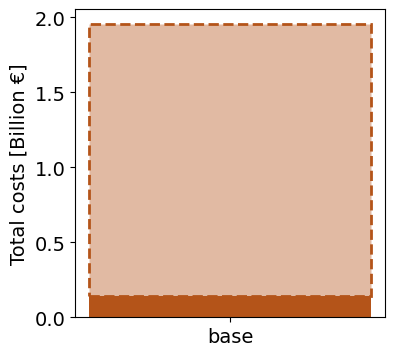

In [142]:
capex_tot = capex['TotalInvestment'].sum() /1e3
opex_tot = opex['TotalOperationalCost'].sum() / 1e3
fig, ax = plt.subplots(figsize=(4, 4))
capex_bars = ax.bar('base', capex_tot, color=brown2)
fill_colors_with_alpha = [mcolors.to_rgba(brown2, alpha=0.4)]
solid_edge_colors = [mcolors.to_rgba(brown2, alpha=1)] 
opex_bars = ax.bar('base', opex_tot, bottom=capex_tot, color=fill_colors_with_alpha, edgecolor=solid_edge_colors, linestyle='--', linewidth=2)


plt.ylabel('Total costs [Billion €]', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)

plt.show()

In [143]:
# Read line capacity data from the transmission data
read_transmission_data = transmission_data[transmission_data['Period'].isin(periods)]

read_transmission_data['LineCapacity'] = transmission_data['transmissionInstalledCap_MW']

line_caps = read_transmission_data[['Period', 'LineCapacity']]

# Filter the data to only include the last period 2035-2040
line_caps_fin = line_caps[line_caps['Period'] == '2035-2040']

# Filter the data to only include the capactiy of the lines
line_caps_fin = line_caps_fin[['LineCapacity']]

# Reset index and start the index from 1 instead of 0
line_caps_fin.reset_index(drop=True, inplace=True)
line_caps_fin.index += 1

# Rename index to Line 
line_caps_fin.index.name = 'Line'

# Drop the LineCapacity name, remove the naming completely
line_caps_fin.columns = ['s_nom_opt']

line_caps_fin

,s_nom_opt
Line,
1,644.40
2,117.00
3,117.00
4,280.62
5,864.27
6,128.25
7,497.25
8,628.65
9,293.40


In [144]:
# Change line_caps_fin to a Series like n.lines.s_nom_opt
line_caps_fin = line_caps_fin.squeeze()

# Change the dtype of the index to string
line_caps_fin.index = line_caps_fin.index.astype(str)


In [145]:
gen_data = operational_data[(operational_data['Period'] == '2035-2040') & (operational_data['Season'].isin(regular_seasons))]

gen_data = gen_data[['Node', 'Scenario', 'Season', 'AllGen_MW']]
# Change Node names from 'BO00' to 'BO0 0' format
gen_data['Node'] = gen_data['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)



# Sum the AllGen_MW in gen_data for all seasons and hours and then average the sums in all the scenarios for a node
gen_data_summed = gen_data.groupby(['Node', 'Scenario']).sum()

#gen_data_mean = gen_data_summed.groupby('Node').mean()
#gen_data_summed_series = gen_data_summed.squeeze()
#print(gen_data_summed_series)
#print(gen_data_summed_series.sum())


In [146]:
period = '2030-2035'

gen_data_bus_reg = operational_data[(operational_data['Period'] == period) & (operational_data['Season'].isin(regular_seasons))]
gen_data_bus_reg = gen_data_bus_reg[['Node', 'Scenario', 'AllGen_MW']]
gen_data_bus_reg['Node'] = gen_data_bus_reg['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)
gen_data_bus_reg['AllGen_MW'] = gen_data_bus_reg['AllGen_MW'] * season_scale[0] 
# Multiply gen_data_bus_reg['AllGen_MW'] with the probability of the corresponding scenario
gen_data_bus_reg['AllGen_MW'] = gen_data_bus_reg['AllGen_MW'] * prob_scenarios[gen_data_bus_reg['Scenario'].values[0]]
gen_data_bus_reg = gen_data_bus_reg[['Node', 'AllGen_MW']]
gen_data_bus_reg = gen_data_bus_reg.groupby('Node').sum()

gen_data_bus_reg = gen_data_bus_reg.squeeze()
print(gen_data_bus_reg)
print(gen_data_bus_reg.sum())   


gen_data_bus_peak = operational_data[(operational_data['Period'] == period) & (operational_data['Season'].isin(peak_seasons))]
gen_data_bus_peak = gen_data_bus_peak[['Node', 'Scenario', 'AllGen_MW']]
gen_data_bus_peak['Node'] = gen_data_bus_peak['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)
gen_data_bus_peak['AllGen_MW'] = gen_data_bus_peak['AllGen_MW'] * season_scale[5]
# Multiply gen_data_bus_peak['AllGen_MW'] with the probability of the corresponding scenario
gen_data_bus_peak['AllGen_MW'] = gen_data_bus_peak['AllGen_MW'] * prob_scenarios[gen_data_bus_peak['Scenario'].values[0]]
gen_data_bus_peak = gen_data_bus_peak[['Node', 'AllGen_MW']]
gen_data_bus_peak = gen_data_bus_peak.groupby('Node').sum()

gen_data_bus_peak = gen_data_bus_peak.squeeze()
print(gen_data_bus_peak)
print(gen_data_bus_peak.sum())

gen_data_bus = gen_data_bus_reg + gen_data_bus_peak
print(gen_data_bus)
print(gen_data_bus.sum())

Node
BO0 0     2.388364e+05
BO0 1     3.345906e+05
BO0 10    7.022105e+01
BO0 11    4.698909e+06
BO0 12    3.021896e-10
BO0 13    2.085389e-10
BO0 14    1.775815e+06
BO0 15    9.928066e+05
BO0 16    1.797449e-10
BO0 17    1.777490e-10
BO0 18    2.975987e+05
BO0 19    7.599399e+04
BO0 2     2.675644e+04
BO0 20    1.004343e-10
BO0 21    2.603966e-10
BO0 22    2.194573e-10
BO0 23    6.066764e+05
BO0 24    4.192570e+03
BO0 25    1.809086e+05
BO0 26    2.064708e-10
BO0 27    4.505758e+04
BO0 28    3.138934e+04
BO0 29    4.180306e+05
BO0 3     2.448854e+05
BO0 4     1.685666e-09
BO0 5     3.402062e+06
BO0 6     7.952436e+04
BO0 7     2.577847e+06
BO0 8     3.205420e+01
BO0 9     2.620967e-10
Name: AllGen_MW, dtype: float64
16031983.107856315
Node
BO0 0     1.665030e+03
BO0 1     4.876913e+03
BO0 10    2.596227e-11
BO0 11    2.635191e+04
BO0 12    1.288538e-12
BO0 13    8.973767e-13
BO0 14    1.002637e+04
BO0 15    6.760783e+03
BO0 16    6.753534e-13
BO0 17    7.010373e-13
BO0 18    1.959093e

c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[

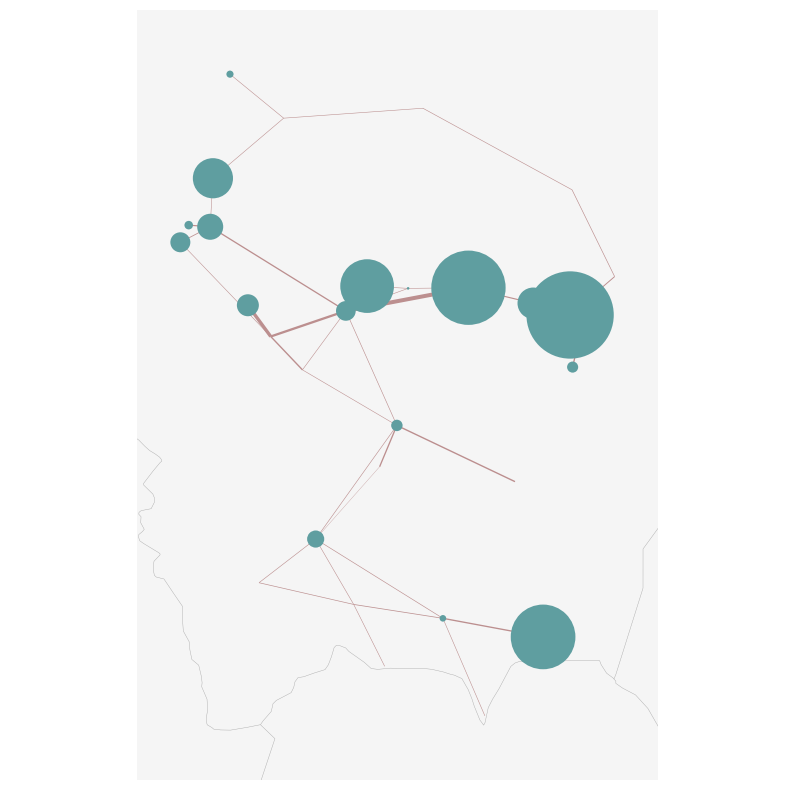

In [147]:
import pypsa

network_fin = pypsa.Network('C:/Users/marih/OneDrive/Documents/pypsa-2802/pypsa-earth/base_30/BVAL_2039.nc')

max_node_size = 0.1  # maximum size of a node for plotting purposes [used in plots]

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n = network_fin


# Sum the power generation for each generator over all timesteps
total_generation = n.generators_t.p.sum()

# Create a DataFrame by merging total generation with bus IDs for each generator
gen_to_bus = pd.DataFrame({'generation': total_generation}).merge(n.generators[['bus']], left_index=True, right_on='Generator')

# Group by 'bus' and sum the generation, resulting in a Series
gen_per_bus = gen_to_bus.groupby('bus')['generation'].sum()


n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=gen_data_bus/15000000,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=line_caps_fin / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

In [148]:
technologies_path = 'data_pypsa/technologies.xlsx'

# Load new technologies
new_techs_df = pd.read_excel(technologies_path, sheet_name='technologies_pypsa')
new_technologies = sorted(set(new_techs_df['New_names']))
 
# Map new technology names to old names for lookup
tech_name_map = new_techs_df.set_index('New_names')['Old_names'].to_dict()

# Remove spaces in tech_name_map keys
tech_name_map = {key.replace(" ", ""): value for key, value in tech_name_map.items()}

period = period_intervals[-1]

gen_p_nom = investment_data[(investment_data['Period'] == period) & (investment_data['genInstalledCap_MW'] > 1e-3)]
gen_p_nom = gen_p_nom[['Node', 'GeneratorType', 'genInstalledCap_MW']]

gen_p_nom['Node'] = gen_p_nom['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)

# Change GeneratorType names from EMPIRE names to PyPSA names using tech_name_map
gen_p_nom['GeneratorType'] = gen_p_nom['GeneratorType'].map(tech_name_map)

# Rename the GeneratorType column to carrier and the Node column to bus
gen_p_nom = gen_p_nom.rename(columns={'GeneratorType': 'carrier', 'Node': 'bus'})

# Rename the genInstalledCap_MW column to p_nom and the Generator column to index
gen_p_nom = gen_p_nom.rename(columns={'genInstalledCap_MW': 'p_nom'})

gen_p_nom = gen_p_nom.groupby(['bus', 'carrier']).sum()

gen_p_nom = gen_p_nom.squeeze()

gen_p_nom


bus     carrier
BO0 0   OCGT       146.340009
        hydro      120.000000
        ror          7.540000
BO0 1   OCGT       447.210647
BO0 10  oil          3.610000
BO0 11  CCGT       521.720000
        biomass      5.000000
BO0 14  hydro      156.360000
        ror        124.000000
BO0 15  hydro       17.940000
        ror        153.570000
BO0 18  hydro        6.130000
        ror          1.970000
        solar      100.020000
BO0 2   hydro        7.600000
BO0 23  biomass     96.720000
BO0 24  onwind      27.000000
BO0 25  ror          7.550000
        solar       60.060000
BO0 27  hydro        9.720000
BO0 28  biomass      5.000000
        oil          0.700000
BO0 29  hydro       38.400000
        ror         50.790000
BO0 3   OCGT       288.507586
BO0 5   CCGT       379.950000
        OCGT       180.084582
BO0 6   OCGT       162.239626
BO0 7   CCGT       441.400000
BO0 8   oil          2.150000
Name: p_nom, dtype: float64

C:\Users\marih\AppData\Local\Temp\ipykernel_32484\2400589033.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  n.carriers.color['geothermal'] = brown2
C:\Users\marih\AppData\Local\Temp\ipykernel_32484\2400589033.py:22: SettingWithCopyWarn

bus     carrier
BO0 0   OCGT       146.340009
        hydro      120.000000
        ror          7.540000
BO0 1   OCGT       447.210647
BO0 10  oil          3.610000
BO0 11  CCGT       521.720000
        biomass      5.000000
BO0 14  hydro      156.360000
        ror        124.000000
BO0 15  hydro       17.940000
        ror        153.570000
BO0 18  hydro        6.130000
        ror          1.970000
        solar      100.020000
BO0 2   hydro        7.600000
BO0 23  biomass     96.720000
BO0 24  onwind      27.000000
BO0 25  ror          7.550000
        solar       60.060000
BO0 27  hydro        9.720000
BO0 28  biomass      5.000000
        oil          0.700000
BO0 29  hydro       38.400000
        ror         50.790000
BO0 3   OCGT       288.507586
BO0 5   CCGT       379.950000
        OCGT       180.084582
BO0 6   OCGT       162.239626
BO0 7   CCGT       441.400000
BO0 8   oil          2.150000
Name: p_nom, dtype: float64


c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


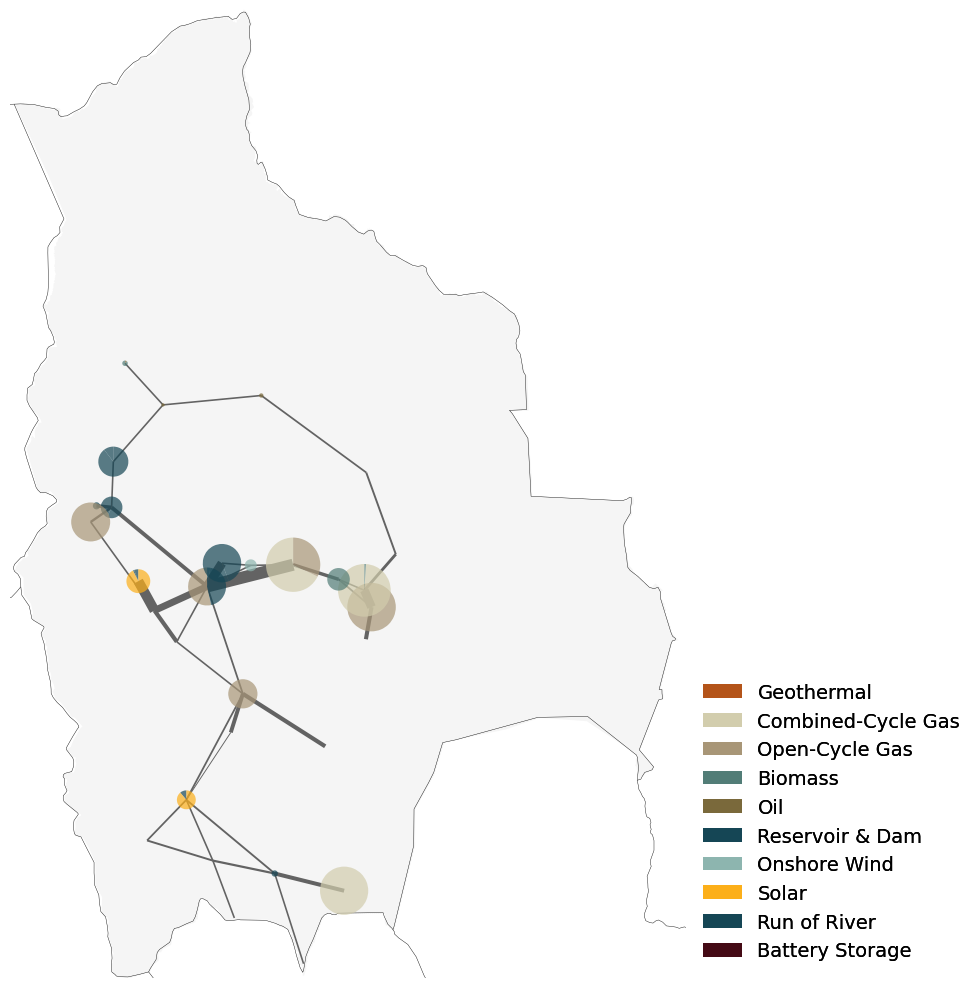

In [149]:
bus_scale = 3e3 
line_scale = 1e2

import pypsa
import geopandas as gpd
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import numpy as np


regions_onshore = gpd.read_file("c:/users/marih/OneDrive/Documents/pypsa-2802/pypsa-earth/resources/shapes/country_shapes.geojson")

# Remove the PHS and load row in n-carriers
if 'PHS' in n.carriers.index:
    n.carriers = n.carriers.drop(index='PHS')
if 'Load' in n.carriers.index:
    n.carriers = n.carriers.drop(index='Load')
n.carriers.color = [beige3, beige2, teal3, brown2, beige1, teal2, teal4, yellow, teal2, brown]
n.carriers.color['geothermal'] = brown2
n.carriers.color['ror'] = teal2
n.carriers.color['hydro'] = teal2
n.carriers.color['battery'] = brown
n.carriers.color['CCGT'] = beige3
n.carriers.color['OCGT'] = beige2
n.carriers.color['oil'] = beige1
n.carriers.color['onwind'] = teal4
n.carriers.color['solar'] = yellow
n.carriers.color['biomass'] = teal3
n.carriers

fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
# gen = n.generators
# gen = gen[~gen['carrier'].str.contains('load')]
# gen = gen.groupby(["bus", "carrier"]).p_nom.sum()

# sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = gen_p_nom #pd.concat([gen, sto])

print(buses)

bus_sizes = buses / bus_scale

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_colors=n.carriers.color,
        bus_alpha=0.7,
        line_widths=line_caps_fin / line_scale,
        link_widths=n.links.p_nom / line_scale,
        line_colors='#636363'	,
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
# circles legend may requite some fine-tuning
legend_circles_dict = {"bbox_to_anchor": (1, 0.6), "labelspacing": 5, **legend_kwargs}
bus_sizes = [50, 500, 1000, 1250]  # in MW
line_sizes = [100, 500, 1000, 1500]  # in MW


# add_legend_circles(
#     ax,
#     [s / bus_scale for s in bus_sizes],
#     [f"{s} MW" for s in bus_sizes],
#     legend_kw=legend_circles_dict,    
# )
# add_legend_lines(
#     ax,
#     [s / line_scale for s in line_sizes],
#     [f"{s} MW" for s in line_sizes],
#     legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
# )
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)


fig.tight_layout()





In [150]:
# Read the load from the excel file Node.xlsx in the sheet ElectricAnnualDemand found in the path 'Data handler/bolivia_v1/Node.xlsx'
load_data = pd.read_excel('Data handler/bolivia_v1/Node.xlsx', sheet_name='ElectricAnnualDemand', skiprows=2)

load_final = load_data[load_data['Period'] == 3]
load_final = load_final[['Nodes', 'ElectricAdjustment in MWh per hour']]
load_final = load_final.rename(columns={'Nodes': 'bus', 'ElectricAdjustment in MWh per hour': 'load'})

# Make load_final into a Series
load_final = load_final.set_index('bus').squeeze()
load_final

bus
BO0 0     2.702628e+06
BO0 1     4.315033e+06
BO0 2     5.189554e+05
BO0 3     2.704586e+06
BO0 4     7.820613e+05
BO0 5     6.767874e+04
BO0 6     6.504817e+05
BO0 7     2.446026e+05
BO0 8     3.571371e+04
BO0 9     9.523108e+05
BO0 10    3.348455e+05
BO0 11    1.549259e+06
BO0 12    1.730543e+05
BO0 13    9.190470e+05
BO0 14    3.519404e+03
BO0 15    1.398294e+05
BO0 16    4.732496e+04
BO0 17    6.785906e+04
BO0 18    1.177746e+04
BO0 19    9.832821e+05
BO0 20    2.418307e+04
BO0 21    3.181099e+05
BO0 22    0.000000e+00
BO0 23    4.149746e+05
BO0 24    2.338072e+05
BO0 25    9.627629e+04
BO0 26    2.088334e+05
BO0 27    1.035401e+06
BO0 28    4.805609e+04
BO0 29    7.048427e+04
Name: load, dtype: float64

c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


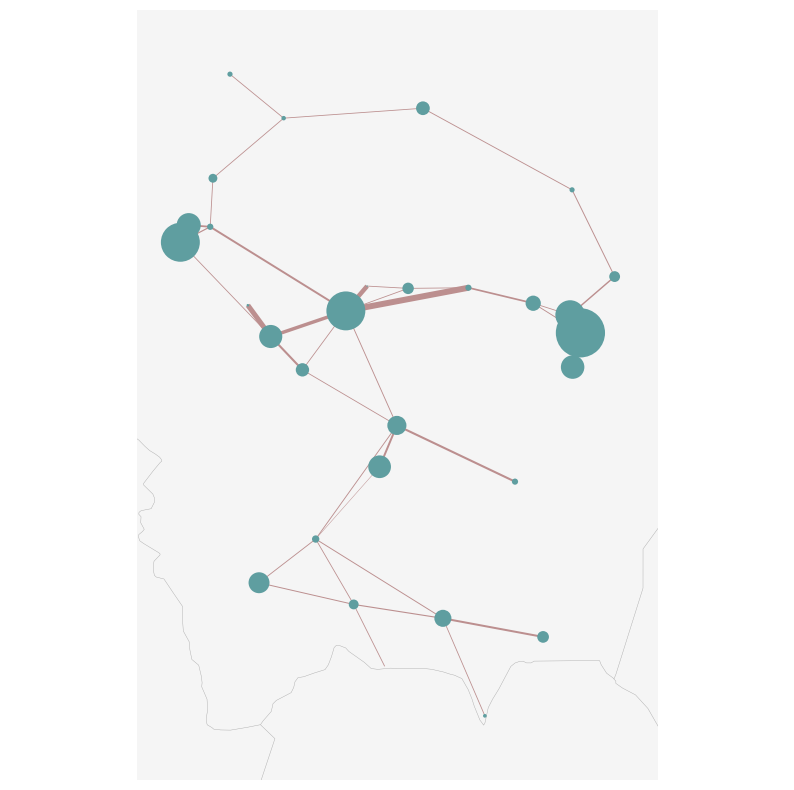

In [151]:

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        load_final
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=line_caps_fin / 2e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

In [152]:
legend_circle_sizes = [s / bus_scale for s in bus_sizes]

legend_circle_sizes

[0.016666666666666666,
 0.16666666666666666,
 0.3333333333333333,
 0.4166666666666667]

In [153]:
# Sum all p_nom values for each bus in buses
buses_sum = buses.groupby('bus').sum()
buses_sum / bus_scale


bus
BO0 0     0.091293
BO0 1     0.149070
BO0 10    0.001203
BO0 11    0.175573
BO0 14    0.093453
BO0 15    0.057170
BO0 18    0.036040
BO0 2     0.002533
BO0 23    0.032240
BO0 24    0.009000
BO0 25    0.022537
BO0 27    0.003240
BO0 28    0.001900
BO0 29    0.029730
BO0 3     0.096169
BO0 5     0.186678
BO0 6     0.054080
BO0 7     0.147133
BO0 8     0.000717
Name: p_nom, dtype: float64

In [154]:
bus_scale

3000.0

In [155]:
# load_shed_cost = node_sheet['NodeLostLoadCost']['C4'].value
# operational_scalar = sum((1+discountrate)**(-j) for j in list(range(0,LeapYearsInvestment)))
# opex_dict = {}
# opex_by_type = []
# for period, num_period in zip(periods, range(1, len(periods) + 1)):
#     sum_opex = 0
#     discount_multiplier = 1
#     if num_period > 1:
#         discount_multiplier = pow(1.0 + discountrate, -LeapYearsInvestment * (num_period - 1))
#     for i in range(scenario_int):
#         for tech in old_names:
#             tech_no_space = tech.replace(" ", "")
#             generated = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))][tech_no_space + '_MW'].sum()
#             generated_peak = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(peak_seasons))][tech_no_space + '_MW'].sum()
#             gen_opex = get_marginal_cost(tech) * (generated * season_scale[0] + generated_peak * season_scale[5]) * prob_scenarios[f'scenario{i+1}'] * discount_multiplier * operational_scalar
#             sum_opex += gen_opex
#         load_shed_opex = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))]['LoadShed_MW'].sum() * load_shed_cost * season_scale[0] * prob_scenarios[f'scenario{i+1}'] * discount_multiplier * operational_scalar
#         sum_opex += load_shed_opex
    
#     opex_dict[period] = sum_opex / 1e6 # in billion euros

# opex = pd.DataFrame(list(opex_dict.items()), columns=['Period', 'TotalOperationalCost'])

In [156]:
# load_shed_opex